<p style="text-align: center; font-size: 30px; font-family: gill sans; font-weight: 600;">
    Importing util python file:
</p>

In [1]:
from accident_analysis_util import *

<p style = "text-align: center; font-size: 30px; font-family: gill sans; font-weight: 600;">
    <a href = "https://api.tfl.gov.uk/swagger/ui/index.html?url=/swagger/docs/v1#!/AccidentStats/AccidentStats_Get">
        <img width = "28px" style = "vertical-align: baseline;" src = "https://seeklogo.com/images/T/Transport_for_London-logo-7A15376D10-seeklogo.com.png" alt = "tfl_logo">
    </a>
    Requesting accident data from 
    <a href = "https://api.tfl.gov.uk/swagger/ui/index.html?url=/swagger/docs/v1#!/AccidentStats/AccidentStats_Get">
        TfL's API</a>:
    <a href = "https://api.tfl.gov.uk/swagger/ui/index.html?url=/swagger/docs/v1#!/AccidentStats/AccidentStats_Get">
        <img width = "28px" style = "vertical-align: baseline;" src = "https://seeklogo.com/images/T/Transport_for_London-logo-7A15376D10-seeklogo.com.png" alt = "tfl_logo">
    </a>
</p>

In [2]:
json = None
for year in trange(2010, 2020, desc = "Years retrieved", unit = "Year"):
    # This TfL API data is accessible without an API key
    url = f'https://api.tfl.gov.uk/AccidentStats/{year}' 
    response = session.get(url)
    response.raise_for_status()

    if json != None:
        json += response.json()
    else:
        json = response.json()

# Make JSON into a DataFrame
df_accidents = pd.DataFrame(json).drop(columns = ['$type', 'id'])

Years retrieved:   0%|          | 0/10 [00:00<?, ?Year/s]

<p style="text-align: center; font-size: 30px; font-family: gill sans; font-weight: 600;">
    Requesting workday population by borough and ward<br>from
    <a href = "https://data.london.gov.uk/dataset/workday-population-by-sex-and-age--borough-and-ward">
        <img height = "25px" style = "vertical-align: middle;" src = "https://data.london.gov.uk/wp-content/themes/bulma-london/img/brand-logo.png" alt = "london_datastore_logo"></a>:
</p>

In [3]:
url = "https://data.london.gov.uk/download/workday-population-by-sex-and-age--borough-and-ward/"\
      "ea37a9f4-3204-45b3-978a-47816a9df337/workday-population-sex-age-borough-ward.xlsx"
response = session.get(url)
response.raise_for_status()
sheet = response.content

# Make Excel spreadsheet with data on both wards and boroughs into a single DataFrame
df_boundaries = pd.read_excel(BytesIO(sheet), sheet_name = 'Persons')\
    .rename(columns = {'Borough': 'borough', 'All categories: Age': 'workday_population'})
columns_to_drop = list(df_boundaries.columns)
del columns_to_drop[1:5]
df_boundaries = df_boundaries.drop(columns = columns_to_drop)

# Make a DataFrame with only the boroughs' workday population data
df_boroughs = df_boundaries.copy()[df_boundaries['Area type'] == 'Local Authority'].reset_index()\
    .drop(columns = ['index', 'borough', 'Area type'])\
        .rename(columns = {'Area': 'borough'})

# Make a DataFrame with only the wards' workday population data
df_wards = df_boundaries.copy()[df_boundaries['Area type'] == 'Ward']

# Delete the data about the tiny wards within the City of London
df_wards = df_wards[df_wards['borough'] != 'City of London'].reset_index()\
    .drop(columns = ['index', 'Area type']).rename(columns = {'Area': 'ward'})

# Consider the City of London to be one ward within the City of London "borough"
# by copying its data from df_boroughs
df_wards.loc[len(df_wards)] = ['City of London', 'City of London', 
    df_boroughs[df_boroughs['borough'] == 'City of London']['workday_population'].iloc[0]]

# Normalise usage of 'St' and 'St.' between datasources
df_wards['ward'] = df_wards['ward'].apply(normalise_saint)

# Creating a 'combined_name' column as a unique identifier of each ward,
# because some boroughs have wards with the same names
df_wards['combined_name'] = df_wards['ward'] + ', ' + df_wards['borough']

<p style="text-align: center; font-size: 30px; font-family: gill sans; font-weight: 600;">
    Savings ward and borough boundaries as shapefiles<br>from
    <a href = "https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london">
        <img height = "25px" style="vertical-align: middle;" src = "https://data.london.gov.uk/wp-content/themes/bulma-london/img/brand-logo.png" alt = "london_datastore_logo"></a>:
</p>

In [4]:
# The most useful workday population info is from the 2011 census (because COVID massively impacted
# the data from the 2021 census), so the ward boundaries used in this project are from 2011.
zip_url = "https://data.london.gov.uk/download/statistical-gis-boundary-files-london/"\
  "9ba8c833-6370-4b11-abdc-314aa020d5e0/statistical-gis-boundaries-london.zip"
file_formats = ['.shp', '.shx', '.dbf']
files_to_save = {'London_Ward_CityMerged': file_formats,
                 'London_Borough_Excluding_MHW': file_formats}
output_filenames = {'wards_2004_to_14': file_formats,
                    'boroughs_1996_to_present': file_formats}
zip_folders = ['statistical-gis-boundaries-london', 'ESRI']
output_folders = ['boundaries']

save_files_from_zip(zip_url, files_to_save, output_filenames = output_filenames,
                    zip_folders = zip_folders, output_folders = output_folders)

<p style="text-align: center; font-size: 30px; font-family: gill sans; font-weight: 600;">
    <a href = "https://geopandas.org/en/stable/docs/reference/api/geopandas.read_file.html">
        <img width = "30px" style = "vertical-align: -10%;" src = "https://geopandas.org/en/latest/_images/geopandas_icon.png" alt = "geopandas_logo">
    </a>
    Storing ward and borough boundaries as GeoDataFrames:
    <a href = "https://geopandas.org/en/stable/docs/reference/api/geopandas.read_file.html">
        <img width = "30px" style = "vertical-align: -10%;" src = "https://geopandas.org/en/latest/_images/geopandas_icon.png" alt = "geopandas_logo">
    </a>
</p>

In [5]:
gdf_ward_boundaries = gpd.read_file('boundaries/wards_2004_to_14.shp')\
    .set_crs(epsg = 27700).to_crs(epsg = 4326)\
        .drop(columns = ['GSS_CODE', "HECTARES", "NONLD_AREA", "LB_GSS_CD", "POLY_ID"])\
            .rename(columns = {'NAME': 'ward', 'BOROUGH': 'borough'})
gdf_borough_boundaries = gpd.read_file('boundaries/boroughs_1996_to_present.shp')\
    .set_crs(epsg = 27700).to_crs(epsg = 4326)\
        .drop(columns = ['GSS_CODE', 'HECTARES', 'NONLD_AREA', 'ONS_INNER', 'SUB_2009', 'SUB_2006'])\
            .rename(columns = {'NAME': 'borough'})

<p style="text-align: center; font-size: 30px; font-family: gill sans; font-weight: 600;">
    Cleaning accidents data to get casualties data by location:
</p>

In [6]:
# Convert latitude and longitude of accidents into shapely points
geometry = [Point(df_accidents['lon'].iloc[row], df_accidents['lat'].iloc[row])
            for row in trange(len(df_accidents), 
                              desc = "Constructing shapely points",
                              unit = " Accidents",
                              colour = 'red')]

# Get a list of all columns in df_accidents except 'casualties'
columns_to_drop = list(df_accidents.columns)
columns_to_drop.remove('casualties')

gdf_casualties = gpd.GeoDataFrame(df_accidents, geometry = geometry)\
    .drop(columns = columns_to_drop).set_crs(crs = gdf_ward_boundaries.crs)

# Clean casualties data by severity for each accident
gdf_casualties['casualties'] = gdf_casualties['casualties'].apply(casualties_severities)
gdf_casualties['slight'] = gdf_casualties['casualties'].apply(lambda x: x['Slight'])
gdf_casualties['serious'] = gdf_casualties['casualties'].apply(lambda x: x['Serious'])
gdf_casualties['fatal'] = gdf_casualties['casualties'].apply(lambda x: x['Fatal'])
gdf_casualties['total'] = gdf_casualties['casualties'].apply(lambda x: sum(x.values()))

# The weighting of weighted_total is arbitrary, but it may give a better indication of overall
# safety in an area than the unweighted total (which consists primarily of slight casualties)
gdf_casualties['weighted_total'] = gdf_casualties\
    .apply(lambda x: x['slight'] + x['serious'] * 15 + x['fatal'] * 250, axis = 1)

gdf_casualties = gdf_casualties.drop(columns = 'casualties')

Constructing shapely points:   0%|          | 0/500046 [00:00<?, ? Accidents/s]

<p style="text-align: center; font-size: 30px; font-family: gill sans; font-weight: 600;">
    Storing the number of casualties by severity (and severity per capita) in GeoDataFrames for both boroughs and wards:
</p>

In [7]:
gdf_ward_casualties = get_area_casualties(gdf_ward_boundaries, gdf_casualties, df_wards)
gdf_borough_casualties = get_area_casualties(gdf_borough_boundaries, gdf_casualties, df_boroughs)

<p style = "text-align: center; font-size: 30px; font-family: gill sans; font-weight: 600;">
    <a href = "https://londonist.com/london/opinion/every-single-london-borough-logo-critiqued">
        <img height = "50px" style = "vertical-align: -50%; border-radius: 7px; border: 5px solid white" src = "https://assets.londonist.com/uploads/2011/02/i875/newlondonistlogo.jpg" alt = "londonist_logo">
    </a>
    Scraping borough logos from
    <a href = "https://londonist.com/london/opinion/every-single-london-borough-logo-critiqued">
        Londonist.com
    </a>
    <a href = "https://londonist.com/london/opinion/every-single-london-borough-logo-critiqued">
        <img height = "50px" style = "vertical-align: -50%; border-radius: 7px; border: 5px solid white" src = "https://assets.londonist.com/uploads/2011/02/i875/newlondonistlogo.jpg" alt = "londonist_logo">
    </a>:
</p>

In [8]:
boroughs = list(df_boroughs['borough'])
boroughs.remove('City of London') # City of London's logo is not found in the londonist.com article
borough_logos = {'City of London': 
                 'https://upload.wikimedia.org/wikipedia/commons/c/c1/City_of_London_logo.svg'}

headers = {'User-Agent': 'Mozilla/5.0'}
response = session.get(
    'https://londonist.com/london/opinion/every-single-london-borough-logo-critiqued',
    headers = headers)
response.raise_for_status()
sel = Selector(response)
logo_urls = sel.css('#body-block img::attr(src)').extract()

for borough in range(len(boroughs)):
    borough_logos[boroughs[borough]] = logo_urls[borough]

<p style="text-align: center; font-size: 30px; font-family: gill sans; font-weight: 600;">
    <a href = "https://python-visualization.github.io/folium/latest/">
        <img height = "35px" style = "vertical-align: -20%;" src = "https://python-visualization.github.io/folium/latest/_images/folium_logo.png" alt = "folium_logo">
    </a>
    Making 
    <a href = "https://python-visualization.github.io/folium/latest/">
        Folium</a>
    maps and savings them as HTML files
    <a href = "https://python-visualization.github.io/folium/latest/">
        <img height = "35px" style = "vertical-align: -20%;" src = "https://python-visualization.github.io/folium/latest/_images/folium_logo.png" alt = "folium_logo">
    </a>
    :
</p>

In [9]:
# Define tile provider for map base
tile_provider = xyz.MapBox
tile_provider['accessToken'] = MAPBOX_API_KEY
tile_provider['url'] = 'https://api.mapbox.com/styles/v1/logandaniels/clv713vet031j01pk77ujfjfz/tiles/'\
    '{z}/{x}/{y}{r}?access_token=' + MAPBOX_API_KEY
tile_provider['min_zoom'] = 10

# Make folium maps
maps_to_make = ['slight', 'serious', 'fatal', 'total', 'weighted_total']
ward_maps = {severity: make_map(severity, gdf_ward_casualties, borough_logos, tile_provider) for severity in
             tqdm(maps_to_make, desc = "Making ward maps", unit = ' Maps', colour = '#5C6F68')}
borough_maps = {severity: make_map(severity, gdf_borough_casualties, borough_logos, tile_provider) for severity in
                tqdm(maps_to_make, desc = "Making borough maps", unit = ' Maps', colour = '#8AA39B')}

# Save maps as HTML files
if not os.path.exists("casualties_by_workday_populations_maps"):
    os.makedirs("casualties_by_workday_populations_maps")
for map in tqdm(ward_maps, desc = "Saving ward maps", unit = "Map", colour = '#95D9C3'):
    ward_maps[map].save(f"casualties_by_workday_populations_maps/{map}_casualties_by_ward.html")
for map in tqdm(borough_maps, desc = "Saving borough maps", unit = "Map", colour = '#A4F9C8'):
    borough_maps[map].save(f"casualties_by_workday_populations_maps/{map}_casualties_by_borough.html")

Making ward maps:   0%|          | 0/5 [00:00<?, ? Maps/s]

Making borough maps:   0%|          | 0/5 [00:00<?, ? Maps/s]

Saving ward maps:   0%|          | 0/5 [00:00<?, ?Map/s]

Saving borough maps:   0%|          | 0/5 [00:00<?, ?Map/s]

<p style="text-align: center; font-size: 30px; font-family: gill sans; font-weight: 600;">
    <a href = "https://plotnine.org/">
        <img height = "70px" style = "vertical-align: -70%; border-radius: 8px; border: 5px solid #441a40" src = "https://plotnine.org/images/logo-540.png" alt = "plotnine_logo">
    </a>
    Plotting every accident with 
    <a href = "https://plotnine.org/">
        Plotnine</a>:
    <a href = "https://plotnine.org/">
        <img height = "70px" style = "vertical-align: -70%; border-radius: 8px; border: 5px solid #441a40" src = "https://plotnine.org/images/logo-540.png" alt = "plotnine_logo">
    </a>
</p>

/Users/logandaniels/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/logandaniels/anaconda3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: london_accidents.png


The file has been saved, working on displaying the plot now


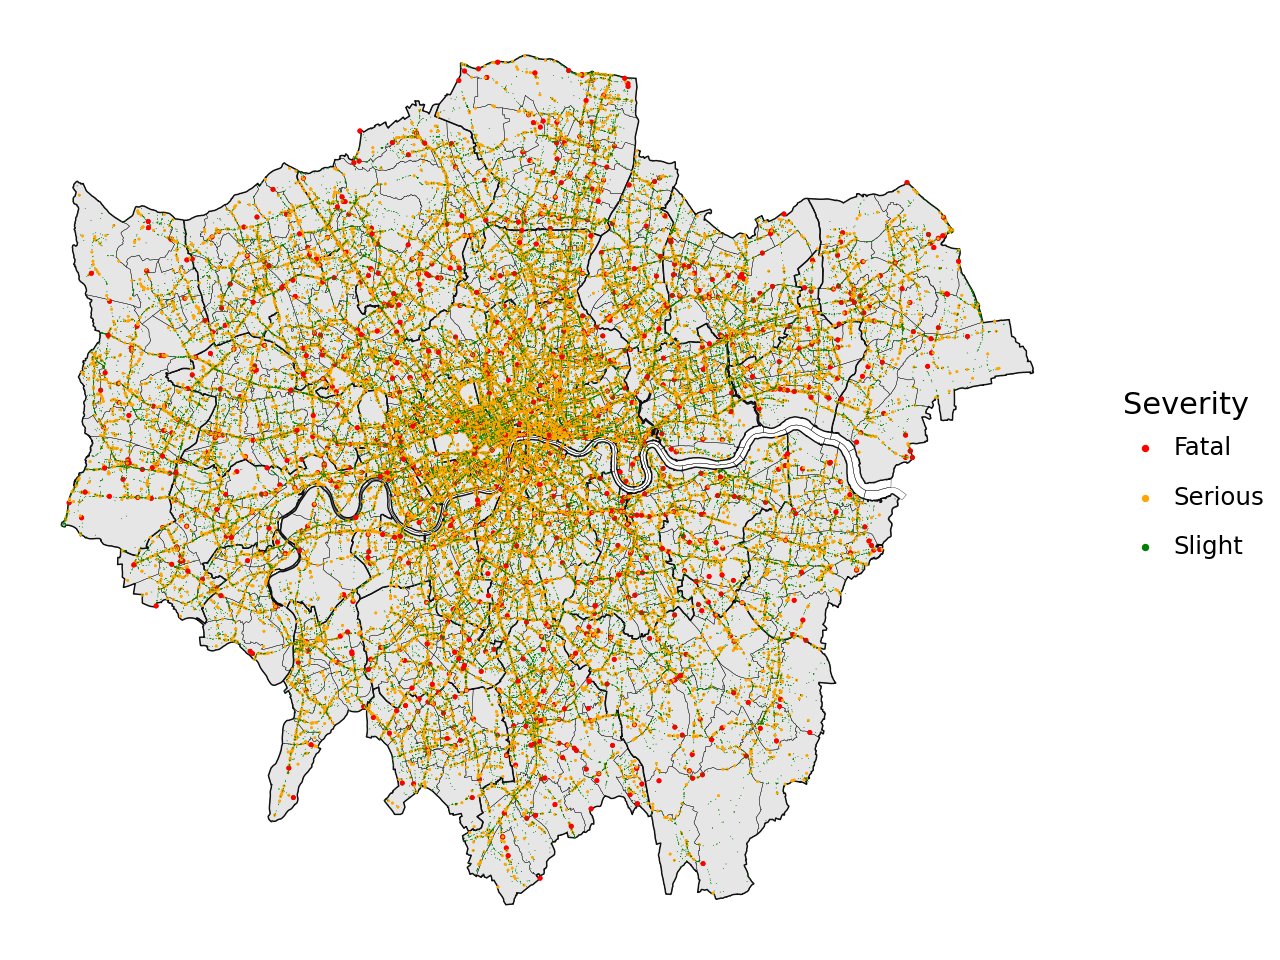

In [10]:
gdf_severities = gdf_casualties.copy()
gdf_severities['Severity'] = gdf_severities.apply(get_severity, axis = 1)
gdf_severities['size'] = gdf_severities['Severity'].apply(get_size)

severities_plot = (
    ggplot()
    + geom_map(gdf_borough_boundaries, fill = '#E6e6e6', size = 0.3)
    + geom_map(gdf_ward_boundaries, fill = None, size = 0.075)
    + geom_point(gdf_severities, aes(x = "geometry.x", y = "geometry.y", fill = 'Severity', size = "size"), stroke = 0)
    + scale_size_radius(range = (0.15, 1))
    + scale_fill_manual(values = ['red', 'orange', 'green'])
    + guides(size = False)
    + theme_minimal()
    + theme(
        panel_grid_major = element_blank(), 
        panel_grid_minor = element_blank(),
        axis_title = element_blank(),
        axis_text = element_blank(),
        ) 
)

# Saving as a png so that it loads quickly in a Streamlit application
severities_plot.save("london_accidents.png", dpi = 1200)
print('The file has been saved, working on displaying the plot now')

severities_plot.show()

<p style = "text-align: center; font-size: 30px; font-family: gill sans; font-weight: 600;">
    Saving accidents by their nearest wards (and boroughs):
</p>

In [11]:
severity_columns = ['slight', 'serious', 'fatal', 'total', 'weighted_total']
per_capita_columns = [item + '_per_capita' for item in severity_columns] # For use later

gdf_points = gdf_casualties.copy().to_crs(gdf_ward_boundaries.crs)
gdf_points['Severity'] = gdf_points.apply(get_severity, axis = 1)
gdf_points['size'] = gdf_points['Severity'].apply(get_size)
gdf_points = gdf_points.drop(columns = severity_columns)
# This process (seeing which ward each accident is nearest too) should take a bit over 1 minute (depending on machinery), please be patient
gdf_points = gpd.sjoin_nearest(gdf_points, gdf_ward_boundaries).reset_index().drop(columns = ['index', 'index_right'])

# Saving wards' points
for row in trange(len(df_wards), desc = "Savings wards' points", unit = " Wards", colour = "purple"):
    ward = df_wards['ward'].iloc[row]
    borough = df_wards['borough'].iloc[row]
    if not os.path.exists(f'data/gdf_points/{borough}'):
        os.makedirs(f'data/gdf_points/{borough}')
    gdf_points[(gdf_points['ward'] == ward) & (gdf_points['borough'] == borough)].drop(columns = ['borough', 'ward'])\
        .to_file(f"data/gdf_points/{borough}/{ward}.shp")

# Saving boroughs' points
for borough in tqdm(df_boroughs['borough'], desc = "Saving boroughs' points", unit = " Boroughs", colour = "pink"):
    gdf_points[gdf_points['borough'] == borough].drop(columns = ['borough', 'ward'])\
        .to_file(f"data/gdf_points/boroughs/{borough}.shp")

/Users/logandaniels/anaconda3/lib/python3.11/site-packages/geopandas/array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Savings wards' points:   0%|          | 0/625 [00:00<?, ? Wards/s]

Saving boroughs' points:   0%|          | 0/33 [00:00<?, ? Boroughs/s]

<p style = "text-align: center; font-size: 30px; font-family: gill sans; font-weight: 600;">
    <a href = "https://streamlit.io/">
        <img height = "35px" style = "vertical-align: -20%;" src = "https://seeklogo.com/images/S/streamlit-logo-1A3B208AE4-seeklogo.com.png" alt = "streamlit_logo">
    </a>
    Saving wards and boroughs' casualties by severity for
    <a href = "https://streamlit.io/">
        Streamlit
    </a>
    application:
    <a href = "https://streamlit.io/">
        <img height = "35px" style = "vertical-align: -20%;" src = "https://seeklogo.com/images/S/streamlit-logo-1A3B208AE4-seeklogo.com.png" alt = "streamlit_logo">
    </a>
</p>

In [12]:
gdf_ward_casualties_per_10000_per_year = gdf_ward_casualties.copy()
for column in tqdm(per_capita_columns,
                   desc = "Converting wards' casualty data to be per 10,000 people per year",
                   unit = 'Column',
                   colour = 'blue'):
        gdf_ward_casualties_per_10000_per_year[column[:-11]] = gdf_ward_casualties_per_10000_per_year[column] * 1000
gdf_ward_casualties_per_10000_per_year = gdf_ward_casualties_per_10000_per_year.drop(columns = per_capita_columns + ['workday_population'])\
        .rename(columns = {'weighted_total': 'weighted'})

gdf_borough_casualties_per_10000_per_year = gdf_borough_casualties.copy()
for column in tqdm(per_capita_columns,
                   desc = "Converting boroughs' casualty data to be per 10,000 people per year",
                   unit = 'Column',
                   colour = 'orange'):
      gdf_borough_casualties_per_10000_per_year[column[:-11]] = gdf_borough_casualties_per_10000_per_year[column] * 1000
gdf_borough_casualties_per_10000_per_year = gdf_borough_casualties_per_10000_per_year\
        .drop(columns = per_capita_columns + ['workday_population']).rename(columns = {'weighted_total': 'weighted'})

gdf_plot_ward_casualties = gdf_ward_casualties_per_10000_per_year.copy()
gdf_plot_ward_casualties['ward'] = gdf_plot_ward_casualties['ward'].apply(spaces_to_breaks)

if not os.path.exists("data/workday_population"):
    os.makedirs("data/workday_population")
gdf_plot_ward_casualties.to_file("data/workday_population/gdf_plot_ward_casualties.shp")
gdf_borough_casualties_per_10000_per_year.to_file("data/workday_population/gdf_plot_borough_casualties.shp")

# Saving borough logos for use in the same Streamlit application
with open('data/borough_logos.pkl', 'wb') as f:
    dump(borough_logos, f)

Converting wards' casualty data to be per 10,000 people per year:   0%|          | 0/5 [00:00<?, ?Column/s]

Converting boroughs' casualty data to be per 10,000 people per year:   0%|          | 0/5 [00:00<?, ?Column/s]